In [1]:
from __future__ import print_function, division
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [2]:
######################################################################
# Load Data
data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../hymenoptera_data'
# image_datasets['train'] ['val'] 
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
# dataloaders['train']  ['val']
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
# dataset_sizes['train'] ['val']
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# folder names
class_names = image_datasets['train'].classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

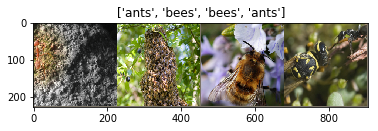

In [3]:
######################################################################
# Visualize a few images

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()
    
# Get a batch of training data
# [batch_size,channels, height, width] [batch_size]
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [4]:
######################################################################
# Training the model
# -  Scheduling the learning rate
# -  Saving the best model
# `scheduler` is an LR scheduler object from `torch.optim.lr_scheduler`

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # losss * batch_size
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [5]:
######################################################################
# Visualizing the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/24
----------
train Loss: 0.6402 Acc: 0.6885
val Loss: 0.2150 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4647 Acc: 0.8197
val Loss: 0.2327 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4569 Acc: 0.8115
val Loss: 0.2471 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4802 Acc: 0.7664
val Loss: 0.5755 Acc: 0.8170

Epoch 4/24
----------
train Loss: 0.6729 Acc: 0.7295
val Loss: 0.4645 Acc: 0.8235

Epoch 5/24
----------
train Loss: 0.5452 Acc: 0.7746
val Loss: 0.3243 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.4758 Acc: 0.7828
val Loss: 0.2192 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3717 Acc: 0.8443
val Loss: 0.2362 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3629 Acc: 0.8484
val Loss: 0.2199 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2681 Acc: 0.8566
val Loss: 0.2023 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3398 Acc: 0.8607
val Loss: 0.1972 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3549 Acc: 0.8402
val Loss: 0.2098 Acc: 0.9216

Ep

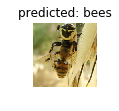

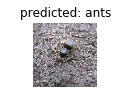

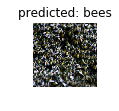

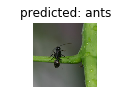

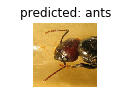

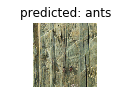

In [7]:
######################################################################
# Finetuning the convnet
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

######################################################################
# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
visualize_model(model_ft)

Epoch 0/24
----------
train Loss: 0.8475 Acc: 0.5574
val Loss: 0.5064 Acc: 0.7451

Epoch 1/24
----------
train Loss: 0.4757 Acc: 0.7992
val Loss: 0.2416 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4400 Acc: 0.7951
val Loss: 0.1845 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.5483 Acc: 0.7869
val Loss: 0.1909 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3664 Acc: 0.8361
val Loss: 0.1812 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3048 Acc: 0.8566
val Loss: 0.4187 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.4082 Acc: 0.8197
val Loss: 0.1493 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.4592 Acc: 0.8074
val Loss: 0.1816 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.4293 Acc: 0.8156
val Loss: 0.1618 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.2930 Acc: 0.8811
val Loss: 0.1909 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2792 Acc: 0.8689
val Loss: 0.1718 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3877 Acc: 0.8402
val Loss: 0.1712 Acc: 0.9412

Ep

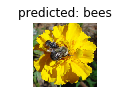

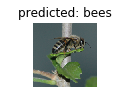

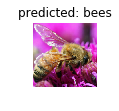

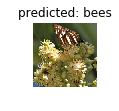

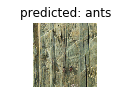

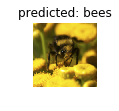

In [8]:
######################################################################
# ConvNet as fixed feature extractor
# Here, we need to freeze all the network except the final layer
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = torch.nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

######################################################################
# Train and evaluate
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)
visualize_model(model_conv)